## LSTM-Image-Captioning

- 编程语言和版本: Python3
- 工具和框架: Keras+TensorFlow
- 环境: Windows/Linux
- IDE: Jupyter Notebook/PyCharm
- 数据集: Flickr8k+MS COCO


**前一阶段工作总结**

之前的工作实现了，采用MS COCO数据集，经过VGG-16网络（在imagenet上）预训练处理得到的图像特征，作为使用原生numpy实现了LSTM网络的输入，然后进一步训练，得到描述结果。总的来说基本实现了LSTM-Image-Captioning的任务。

但工作有几点不足之处，
- 使用的模型太少, 只使用了VGG16（原因是CS231N提供的数据集就是其预训练得到的特征）
改进，换用其他数据集自己进行预训练
- 网络训练太慢太耗时，上次在20分之一的训练集上训练了,就花了3个小时，结果并不理想。没有采用深度学习框架，都是在cpu上计算和运行的，非常耗时。
- 没有评价指标
- 没有将训练之后得到的模型以合适的方式存储
- 没有提供可用的接口

最后两个问题本质是一样，将训练得到的模型参数进行存储封装，那么也就相当于对外提供了接口了，而不是华而不实的网站。！！！！


打算采用的解决方案:
- 数据集：采用flickr8k数据集，相对于COCO来说体积小一些，不需要那么多的计算资源。缺点是需要重新对数据进行预处理，同时也是体积比较小，过拟合可能会比较严重。
- 模型设计：采用keras+tensorflow后端的方式，用经典的几种CNN对输入图像进行预处理。优点是不用关注复杂CNN的实现细节，在GPU上训练，速度较快。缺点是之前的网络不太好重新复用。
- 模型评价：flickr数据集中有相应的打分，比在coco中计算BLEU等要方便。


**后期工作流程**

首先明确接下来要做的目标：
- 预处理flickr8k数据
    - 提取描述
        - train_captions
        - dev_captions
        - test_captions
    - 对描述进行编码(训练集，验证/开发/测试集分别构建)
        - 构建词汇表 vocab
        - 构建词汇表字典 每个单词对应一个索引 idx_to_word word_to_idx
        - 对描述编码 encode_caption
        - 对描述解码 decode_caption
    - 描述正确性指标
    - 预处理flickr图片
        - 构建经典的CNN网络
            - vgg-16
            - vgg-19
            - google net inception v3
            - resNet 
    - 使用构建的网络来预训练图片（都是采用才imagenet上得到的权重）
        - 获得和保存图片对应的特征（vgg-16为例是4096维的特征）
            - train_features
            - dev_features
            - test_features
        - 图片地址（数据集已经下载到本地，也可以是网络url）
            - train_urls
            - dev_urls
            - test_urls
- 构建ImageCaptioning模型
    - NIC: CNN编码+LSTM解码网络结构
    - 正向传播
    - 反向传播
    - 计算loss，计算正确率
    - 采用SGD, ADAM等更新权重参数
- 测试模型
    - 对测试集运用训练好的模型
    - 评价模型准确度
    - 比较几种不同的网络和参数对于模型准确度的影响，并分析原因，反过来验证猜想，如此往复
- 模型的扩展
    - 多语言的支持
- 将模型应用于特定场景和嵌入到某种应用中
    - 部署到移动设备
     - 语音支持


_备注：这几天也学习了PyTorch，特别适合作为学术研究使用的框架，优点在于动态计算图的构建以及强大的自动求导功能。但是没有找到非使用其不可的理由，而且tenforflow目前来说还是业界主导，其加上keras配合使用，在构建复杂网络上目前还是比较有优势的。_


## Flickr8k数据预处理

网址:[这里](http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/KCCA.html)

Download the Flickr 8k Images [Here](http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip)

Download the Flickr 8k Text Data [Here]( http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip)


In [1]:
import os 

FLICKR8K_BASE = "../Datasets/Flickr8k"  # 本地地址

FLICKR8K_DATASET = os.path.join(FLICKR8K_BASE,"Flickr8k_Dataset/Flicker8k_Dataset"  ) # 数据集图像
FLICKR8K_TEXT = os.path.join(FLICKR8K_BASE, "Flickr8k_text" ) # 数据集文本信息

flick8k_token = os.path.join(FLICKR8K_TEXT, "Flickr8k.token.txt")
flick8k_lemma_token = os.path.join(FLICKR8K_TEXT, "Flickr8k.lemma.token.txt")

flick8k_train_images = os.path.join(FLICKR8K_TEXT, "Flickr_8k.trainImages.txt")
flick8k_test_images = os.path.join(FLICKR8K_TEXT, "Flickr_8k.testImages.txt")
flick8k_dev_images = os.path.join(FLICKR8K_TEXT, "Flickr_8k.devImages.txt")

ExpertAnnotations = os.path.join(FLICKR8K_TEXT, "ExpertAnnotations.txt")
CrowdFlowerAnnotations = os.path.join(FLICKR8K_TEXT, "CrowdFlowerAnnotations.txt")

打开文件瞧一瞧

In [4]:
with open(flick8k_token, 'r') as f:
    for i, line in enumerate(f):
        print(line)
        if i == 5:
            break

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting



必须知道所给的数据集格式是怎样，才能在此基础上预处理，才能“为所欲为”。

In [5]:
def tmp_watch_data(filename, watch_first=5):
    """
    看看flickr8k数据集的格式是怎样的。默认每种文本看前6个。
    """
    try:
        with open(filename, 'r') as f:
            print(filename)
            for i, line in enumerate(f):
                print(line)
                if i == watch_first:
                    break
            print('------------------------------------------')
    except Exception as e:
        print('Error: ', e)
            
tmp_filenames = ['flick8k_token', 'flick8k_lemma_token', 'flick8k_train_images',
                'flick8k_test_images', 'flick8k_dev_images', 'ExpertAnnotations',
                 'CrowdFlowerAnnotations'
                ]

for tmp_filename in tmp_filenames:
    tmp_watch_data(tmp_filename)

Error:  [Errno 2] No such file or directory: 'flick8k_token'
Error:  [Errno 2] No such file or directory: 'flick8k_lemma_token'
Error:  [Errno 2] No such file or directory: 'flick8k_train_images'
Error:  [Errno 2] No such file or directory: 'flick8k_test_images'
Error:  [Errno 2] No such file or directory: 'flick8k_dev_images'
Error:  [Errno 2] No such file or directory: 'ExpertAnnotations'
Error:  [Errno 2] No such file or directory: 'CrowdFlowerAnnotations'


错了，tmp_filenames中不应该是文件名称而应该是上面的变量。

In [6]:
tmp_filenames = [flick8k_token, flick8k_lemma_token, flick8k_train_images,
                flick8k_test_images, flick8k_dev_images, ExpertAnnotations,
                 CrowdFlowerAnnotations
                ]

for tmp_filename in tmp_filenames:
    tmp_watch_data(tmp_filename)

../Datasets/Flickr8k\Flickr8k_text\Flickr8k.token.txt
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting

------------------------------------------
../Datasets/Flickr8k\Flickr8k_text\Flickr8k.lemma.token.txt
1305564994_00513f9a5b.jpg#0	A man in street racer armor be examine the tire of another racer 's motorbike .

1305564994_00513f9a5b.jpg#1	Two racer drive a white bike down a road .

1305564994_00513f9a5b.jpg#2	Two motorist be ride along on their vehicle that be oddly design and color .

1305564994_00513f9a5b.jpg#3	Two person be in a small race car drive 

试着将其转换成规格化的数据。

In [10]:
tmp_captions = """1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
"""

tmp_var1 = tmp_captions.strip().split('\n')
print(type(tmp_var1), len(tmp_var1), tmp_var1)

<class 'list'> 6 ['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .', '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting']


In [11]:
for tmp_caption in tmp_var1:
    tmp_var2 = tmp_caption.strip().split('\t')
    print(type(tmp_var2), len(tmp_var2), tmp_var2)
    
    

<class 'list'> 2 ['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg#1', 'A girl going into a wooden building .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg#2', 'A little girl climbing into a wooden playhouse .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg#3', 'A little girl climbing the stairs to her playhouse .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg#4', 'A little girl in a pink dress going into a wooden cabin .']
<class 'list'> 2 ['1001773457_577c3a7d70.jpg#0', 'A black dog and a spotted dog are fighting']


In [14]:
for tmp_caption in tmp_var1:
    tmp_var2 = tmp_caption.strip().split('\t')
    tmp_var2[0] = tmp_var2[0][:-2]
    print(type(tmp_var2), len(tmp_var2), tmp_var2)
    

<class 'list'> 2 ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .']
<class 'list'> 2 ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .']
<class 'list'> 2 ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting']


In [15]:
tmp_dict = {}
for tmp_caption in tmp_var1:
    tmp_var2 = tmp_caption.strip().split('\t')
    tmp_var2[0] = tmp_var2[0][:-2]
#     print(type(tmp_var2), len(tmp_var2), tmp_var2)
    if tmp_var2[0] in tmp_dict:
        tmp_dict[ tmp_var2[0] ].append( tmp_var2[1] )
    else:
        tmp_dict[ tmp_var2[0] ] = [ tmp_var2[1] ]
        
print(type(tmp_dict), len(tmp_dict), tmp_dict)

<class 'dict'> 2 {'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting']}


In [21]:

def get_all_captions_dict(filename):
    captions_dict = {}
    try:
        with open(filename, 'r') as f:
            print(filename)
            for i, line in enumerate(f):
                tmp_list = line.strip().split('\t')
                tmp_list[0] = tmp_list[0][:-2]
                if tmp_list[0] in captions_dict:
                    captions_dict [ tmp_list[0] ].append( tmp_list[1] )
                else:
                    captions_dict [ tmp_list[0] ] = [ tmp_list[1] ]
                
            print('------------------------------------------')
    except Exception as e:
        print('Error: ', e)
    return captions_dict

all_captions_dict = get_all_captions_dict(flick8k_token)
print(type(all_captions_dict), len(all_captions_dict))

tmp_cnt = 5
for k, v in all_captions_dict.items():
    print(k,':', v)
    if tmp_cnt == 0:
        break
    else:
        tmp_cnt -= 1

../Datasets/Flickr8k\Flickr8k_text\Flickr8k.token.txt
------------------------------------------
<class 'dict'> 8092
1000268201_693b08cb0e.jpg : ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
1001773457_577c3a7d70.jpg : ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
1002674143_1b742ab4b8.jpg : ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in t

In [22]:
all_lemma_captions_dict = get_all_captions_dict(flick8k_lemma_token)
print(type(all_lemma_captions_dict), len(all_lemma_captions_dict))

tmp_cnt = 5
for k, v in all_lemma_captions_dict.items():
    print(k,':', v)
    if tmp_cnt == 0:
        break
    else:
        tmp_cnt -= 1

../Datasets/Flickr8k\Flickr8k_text\Flickr8k.lemma.token.txt
------------------------------------------
<class 'dict'> 8092
1305564994_00513f9a5b.jpg : ["A man in street racer armor be examine the tire of another racer 's motorbike .", 'Two racer drive a white bike down a road .', 'Two motorist be ride along on their vehicle that be oddly design and color .', 'Two person be in a small race car drive by a green hill .', 'Two person in race uniform in a street car .']
1351764581_4d4fb1b40f.jpg : ['A firefighter extinguish a fire under the hood of a car .', 'a fireman spray water into the hood of small white car on a jack', 'A fireman spray inside the open hood of small white car , on a jack .', 'A fireman use a firehose on a car engine that be up on a carjack .', 'Firefighter use water to extinguish a car that be on fire .']
1358089136_976e3d2e30.jpg : ['A boy sand surf down a hill', 'A man be attempt to surf down a hill make of sand on a sunny day .', 'A man be slide down a huge sand dun

根据图片名称，构建所有图片地址列表，根据地址读取图片，作为网络的输入。在上面`get_all_captions_dict`方法的基础上改。

In [23]:
def get_all_captions_dict(filename, dataset_folder= FLICKR8K_DATASET):
    captions_dict = {}
    images_urls = []
    try:
        with open(filename, 'r') as f:
            print(filename)
            for i, line in enumerate(f):
                tmp_list = line.strip().split('\t')
                tmp_list[0] = tmp_list[0][:-2]
                image_url = os.path.join(dataset_folder, tmp_list[0])
                images_urls.append( image_url )
                
                if tmp_list[0] in captions_dict:
                    captions_dict [ tmp_list[0] ].append( tmp_list[1] )
                else:
                    captions_dict [ tmp_list[0] ] = [ tmp_list[1] ]
                
            print('------------------------------------------')
    except Exception as e:
        print('Error: ', e)
    return captions_dict, images_urls

all_captions_dict, all_images_urls = get_all_captions_dict(flick8k_token)
print(type(all_captions_dict), len(all_captions_dict))
print(type(all_images_urls), len(all_images_urls))

../Datasets/Flickr8k\Flickr8k_text\Flickr8k.token.txt
------------------------------------------
<class 'dict'> 8092
<class 'list'> 40460


这样是不对的，出现了重复。试着为captions_dict增加`url`键值。

In [24]:
def get_all_captions_dict(filename, dataset_folder= FLICKR8K_DATASET):
    captions_dict = { }
    try:
        with open(filename, 'r') as f:
            print(filename)
            for i, line in enumerate(f):
                tmp_list = line.strip().split('\t')
                tmp_list[0] = tmp_list[0][:-2]
                
#                 images_urls.append( image_url )
                
                if tmp_list[0] in captions_dict:
                    captions_dict [ tmp_list[0] ]['captions'].append( tmp_list[1] )
                else:
                    captions_dict [ tmp_list[0] ] = { }
                    captions_dict [ tmp_list[0] ]['captions'] = [ tmp_list[1] ]
                    
                image_url = os.path.join(dataset_folder, tmp_list[0])
                captions_dict[ tmp_list[0] ]['url'] = image_url
                
            print('------------------------------------------')
    except Exception as e:
        print('Error: ', e)
    return captions_dict

all_captions_dict = get_all_captions_dict(flick8k_token)
print(type(all_captions_dict), len(all_captions_dict))

tmp_cnt = 5
for k, v in all_captions_dict.items():
    print(k,':', v)
    if tmp_cnt == 0:
        break
    else:
        tmp_cnt -= 1

../Datasets/Flickr8k\Flickr8k_text\Flickr8k.token.txt
------------------------------------------
<class 'dict'> 8092
1000268201_693b08cb0e.jpg : {'captions': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], 'url': '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg'}
1001773457_577c3a7d70.jpg : {'captions': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], 'url': '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\1001773457_577c3a7d70

In [25]:
from PIL import Image
tmp_image_filename = '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg'
try:
    Image.open(tmp_image_filename)
except Exception as e:
    print('Error: ', e)

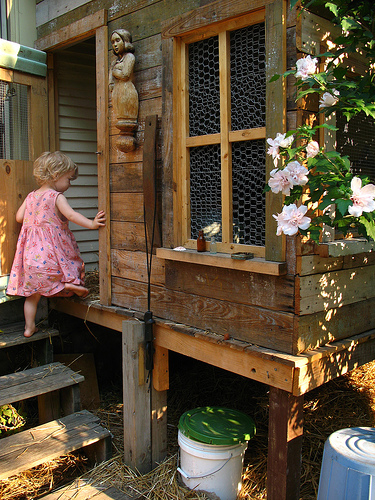

In [26]:
Image.open(tmp_image_filename)

证明得到的路径正确，能够打开对应的图片，这为之后的图片输入进行训练打下了基础。目前为止`all_captions_dict`这个预处理得到的字典还是比较重要的，为了避免每次都重新运行，所以先将其保存到文件中，方便起见保存为pickle文件。

In [28]:
import pickle

try:
    with open('save/all_captions_dict.pyc', 'wb') as save_all_captions_dict:
        pickle.dump(all_captions_dict, save_all_captions_dict)
except Exception as e:
    print('Error: ',e)

数据腌制成功，需要的时候就从文件中再读回来。

In [29]:
import pickle

try:
    with open('save/all_captions_dict.pyc', 'rb') as load_all_captions_dict:
        all_captions_dict = pickle.load(load_all_captions_dict)
except Exception as e:
    print('Error: ', e)
print(type(all_captions_dict), len(all_captions_dict))

<class 'dict'> 8092


需要对，训练、开发（验证）、测试集数据分别进行预处理。



In [36]:
tmp_train_images ="""2513260012_03d33305cf.jpg

2903617548_d3e38d7f88.jpg

3338291921_fe7ae0c8f8.jpg

488416045_1c6d903fe0.jpg

2644326817_8f45080b87.jpg

218342358_1755a9cce1.jpg
"""

tmp_var1 = tmp_train_images.strip().split('\n')
print(type(tmp_var1), len(tmp_var1), tmp_var1)

<class 'list'> 11 ['2513260012_03d33305cf.jpg', '', '2903617548_d3e38d7f88.jpg', '', '3338291921_fe7ae0c8f8.jpg', '', '488416045_1c6d903fe0.jpg', '', '2644326817_8f45080b87.jpg', '', '218342358_1755a9cce1.jpg']


In [38]:
 with open(flick8k_train_images, 'r') as f:
        for i, line in enumerate(f):
            image_file_name = line.strip()
            print(type(image_file_name),image_file_name )


<class 'str'> 2513260012_03d33305cf.jpg
<class 'str'> 2903617548_d3e38d7f88.jpg
<class 'str'> 3338291921_fe7ae0c8f8.jpg
<class 'str'> 488416045_1c6d903fe0.jpg
<class 'str'> 2644326817_8f45080b87.jpg
<class 'str'> 218342358_1755a9cce1.jpg
<class 'str'> 2501968935_02f2cd8079.jpg
<class 'str'> 2699342860_5288e203ea.jpg
<class 'str'> 2638369467_8fc251595b.jpg
<class 'str'> 2926786902_815a99a154.jpg
<class 'str'> 2851304910_b5721199bc.jpg
<class 'str'> 3423802527_94bd2b23b0.jpg
<class 'str'> 3356369156_074750c6cc.jpg
<class 'str'> 2294598473_40637b5c04.jpg
<class 'str'> 1191338263_a4fa073154.jpg
<class 'str'> 2380765956_6313d8cae3.jpg
<class 'str'> 3197891333_b1b0fd1702.jpg
<class 'str'> 3119887967_271a097464.jpg
<class 'str'> 2276499757_b44dc6f8ce.jpg
<class 'str'> 2506892928_7e79bec613.jpg
<class 'str'> 2187222896_c206d63396.jpg
<class 'str'> 2826769554_85c90864c9.jpg
<class 'str'> 3097196395_ec06075389.jpg
<class 'str'> 3603116579_4a28a932e2.jpg
<class 'str'> 3339263085_6db9fd0981.jpg
<c

<class 'str'> 2558312618_13d362df66.jpg
<class 'str'> 3665996775_6d7d9a46f1.jpg
<class 'str'> 3336831820_5c5df4b033.jpg
<class 'str'> 2615811117_42b1838205.jpg
<class 'str'> 2314732154_83bc7f7314.jpg
<class 'str'> 2363540508_9dd1ccf7c7.jpg
<class 'str'> 1355703632_5683a4b6fb.jpg
<class 'str'> 3277824093_299cbb3138.jpg
<class 'str'> 3446762868_06e9d9d899.jpg
<class 'str'> 3048211972_db71d104c2.jpg
<class 'str'> 426805536_d1d5e68c17.jpg
<class 'str'> 441817653_fbdf83060b.jpg
<class 'str'> 1055753357_4fa3d8d693.jpg
<class 'str'> 2325816912_b3bb41cdbb.jpg
<class 'str'> 3060594966_030658d318.jpg
<class 'str'> 3038045802_93f2cd5fbc.jpg
<class 'str'> 812196663_0c969970b5.jpg
<class 'str'> 3533660418_f3a73a257c.jpg
<class 'str'> 3613264553_97b687f172.jpg
<class 'str'> 2603690144_7a28b1d13c.jpg
<class 'str'> 3401437960_7da856e004.jpg
<class 'str'> 2266142543_b2de18c081.jpg
<class 'str'> 3683644335_b70bed1d83.jpg
<class 'str'> 2626158969_ac09aeb88d.jpg
<class 'str'> 3127888173_9a9a8ac3bd.jpg
<cl

<class 'str'> 3587941206_36769c3f1d.jpg
<class 'str'> 2831672255_d779807c14.jpg
<class 'str'> 481827288_a688be7913.jpg
<class 'str'> 380537190_11d6c0a412.jpg
<class 'str'> 2993388841_6746140656.jpg
<class 'str'> 2537197415_af7c30dfc8.jpg
<class 'str'> 484896012_7787d04f41.jpg
<class 'str'> 1245022983_fb329886dd.jpg
<class 'str'> 1918573100_d31cbb6b77.jpg
<class 'str'> 1505686764_9e3bcd854a.jpg
<class 'str'> 2178064851_bb39652d28.jpg
<class 'str'> 241345427_ece0d186c2.jpg
<class 'str'> 3169394115_2193158cee.jpg
<class 'str'> 3591170729_406fdb74e5.jpg
<class 'str'> 3576060775_d9121519cc.jpg
<class 'str'> 2521938802_853224f378.jpg
<class 'str'> 1977827746_4e13d7e19f.jpg
<class 'str'> 3482668767_66004ce736.jpg
<class 'str'> 2297744130_f571f3a239.jpg
<class 'str'> 3403797144_53e49412ec.jpg
<class 'str'> 3612484827_0e479f9ee8.jpg
<class 'str'> 2131762850_5293a288d9.jpg
<class 'str'> 3654103642_075f8af4f4.jpg
<class 'str'> 3472540184_b0420b921a.jpg
<class 'str'> 2801851082_8c3c480c0f.jpg
<cla

<class 'str'> 3600909823_ce72c26e66.jpg
<class 'str'> 3038941104_17ee91fc03.jpg
<class 'str'> 3708244207_0d3a2b2f92.jpg
<class 'str'> 3139238055_2817a0c7d8.jpg
<class 'str'> 2203286182_b453e9d176.jpg
<class 'str'> 3125041578_c1f2d73b6d.jpg
<class 'str'> 412082368_371df946b3.jpg
<class 'str'> 446138054_d40c66d5f0.jpg
<class 'str'> 3324375078_9441f72898.jpg
<class 'str'> 3138746531_f6b816c126.jpg
<class 'str'> 116409198_0fe0c94f3b.jpg
<class 'str'> 3730457171_e66dde8c91.jpg
<class 'str'> 3452982513_36f2bc81fa.jpg
<class 'str'> 3710353645_8fbfaa4175.jpg
<class 'str'> 583087629_a09334e1fb.jpg
<class 'str'> 369047365_35476becc9.jpg
<class 'str'> 3041384194_04316bd416.jpg
<class 'str'> 539667015_fd0a3bea07.jpg
<class 'str'> 2272750492_91e8f67328.jpg
<class 'str'> 3640348910_fcd627ec66.jpg
<class 'str'> 2744600462_5804577296.jpg
<class 'str'> 2363006088_b3e3aa5c0b.jpg
<class 'str'> 267836606_bbea2267c8.jpg
<class 'str'> 2860035355_3fe7a5caa4.jpg
<class 'str'> 97731718_eb7ba71fd3.jpg
<class 's

<class 'str'> 1428641354_f7453afbea.jpg
<class 'str'> 1405221276_21634dcd58.jpg
<class 'str'> 3687996569_99163a41c3.jpg
<class 'str'> 578644583_da3ff18dd1.jpg
<class 'str'> 3546474710_903c3c9fd3.jpg
<class 'str'> 1670592963_39731a3dac.jpg
<class 'str'> 3017220118_6a9212dfdb.jpg
<class 'str'> 485741580_ab523fa657.jpg
<class 'str'> 2831215155_07ba8f1805.jpg
<class 'str'> 3359089834_263e529c71.jpg
<class 'str'> 365584746_681f33fa46.jpg
<class 'str'> 241345533_99c731403a.jpg
<class 'str'> 3250589803_3f440ba781.jpg
<class 'str'> 2178306830_6af49375b4.jpg
<class 'str'> 2636876892_9353521a1c.jpg
<class 'str'> 774009278_8e75b7d498.jpg
<class 'str'> 3362871440_6c0f27c480.jpg
<class 'str'> 3021780428_497542a072.jpg
<class 'str'> 2949497756_be8e58e6bd.jpg
<class 'str'> 3649916507_b88a3d2082.jpg
<class 'str'> 2079110798_ad1370a646.jpg
<class 'str'> 1001773457_577c3a7d70.jpg
<class 'str'> 367925122_335ed279a8.jpg
<class 'str'> 506478284_7cf8bdbe36.jpg
<class 'str'> 2833582518_074bef3ed6.jpg
<class 

In [39]:
def get_images_filenames(filename, verbose_name, dataset_folder= FLICKR8K_DATASET):
    """
    从flick8k_train_images,flick8k_test_images, flick8k_dev_images获取图片文件名
    """
    images_filenames =  []
    images_urls = []
    
    image_types = set(['train', 'dev', 'test'])
    if verbose_name not in image_types:
        return [], []
    
    try:
        with open(filename, 'r') as f:
            for i, line in enumerate(f):
                # image_file_name = line.strip().split('\n')
                image_file_name = line.strip()
                image_url = os.path.join(dataset_folder, image_file_name)
                images_filenames.append(image_file_name)
                images_urls.append(image_url)
       
    except Exception as e:
        print('Error: ', e)
    return images_filenames, images_urls

train_images_filenames, train_images_urls = get_images_filenames(flick8k_train_images,
                                                                'train')
print(type(train_images_filenames), len(train_images_filenames))
print(type(train_images_urls), len(train_images_urls))

<class 'list'> 6000
<class 'list'> 6000


In [40]:
train_images_filenames[:5]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg']

In [41]:
train_images_urls[:5]

['../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\2513260012_03d33305cf.jpg',
 '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\2903617548_d3e38d7f88.jpg',
 '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\3338291921_fe7ae0c8f8.jpg',
 '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\488416045_1c6d903fe0.jpg',
 '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\2644326817_8f45080b87.jpg']

In [43]:
dev_images_filenames, dev_images_urls = get_images_filenames(flick8k_dev_images,
                                                                'dev')
print('dev_images_filenames: ', type(dev_images_filenames), len(dev_images_filenames))
print('dev_images_urls', type(dev_images_urls), len(dev_images_urls))
print(dev_images_filenames[:5])
print(dev_images_urls[:5])

print('---------------------------------------------------------')

test_images_filenames, test_images_urls = get_images_filenames(flick8k_test_images,
                                                                'test')
print('test_images_filenames: ', type(test_images_filenames), len(test_images_filenames))
print('test_images_urls', type(test_images_urls), len(test_images_urls))
print(test_images_filenames[:5])
print(test_images_urls[:5])

dev_images_filenames:  <class 'list'> 1000
dev_images_urls <class 'list'> 1000
['2090545563_a4e66ec76b.jpg', '3393035454_2d2370ffd4.jpg', '3695064885_a6922f06b2.jpg', '1679557684_50a206e4a9.jpg', '3582685410_05315a15b8.jpg']
['../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\2090545563_a4e66ec76b.jpg', '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\3393035454_2d2370ffd4.jpg', '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\3695064885_a6922f06b2.jpg', '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\1679557684_50a206e4a9.jpg', '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\3582685410_05315a15b8.jpg']
---------------------------------------------------------
test_images_filenames:  <class 'list'> 1000
test_images_urls <class 'list'> 1000
['3385593926_d3e9c21170.jpg', '2677656448_6b7e7702af.jpg', '311146855_0b65fdb169.jpg', '1258913059_07c613f7ff.jpg', '241347760_d44c8d3a01.jpg']
['../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Datas

然后根据训练数据构建(训练)词汇表

In [44]:
tmp_train_filenames = train_images_filenames[:5]
tmp_train_urls = train_images_urls[:5]

for tmp_train_filename in tmp_train_filenames:
    tmp_train_captions = all_captions_dict[ tmp_train_filename ]['captions']
    print(type(tmp_train_captions), len(tmp_train_captions), tmp_train_captions)

<class 'list'> 5 ['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']
<class 'list'> 5 ['A little baby plays croquet .', 'A little girl plays croquet next to a truck .', 'The child is playing croquette by the truck .', 'The kid is in front of a car with a put and a ball .', 'The little boy is playing with a croquet hammer and ball beside the car .']
<class 'list'> 5 ['A brown dog in the snow has something hot pink in its mouth .', 'A brown dog in the snow holding a pink hat .', 'A brown dog is holding a pink shirt in the snow .', 'A dog is carrying something pink in its mouth while walking through the snow .', 'A dog with something pink in its mouth is looking forward .']
<class 'list'> 5 ['A brown dog is running along a beach .', 'A brown dog wearing a black collar running across the bea

In [45]:
tmp_caption = 'A brown dog is running along a beach .'
tmp_caption_words =  tmp_caption.split()
print(type(tmp_caption_words), len(tmp_caption_words), tmp_caption_words)

<class 'list'> 9 ['A', 'brown', 'dog', 'is', 'running', 'along', 'a', 'beach', '.']


In [46]:
tmp_unique_words = set(tmp_caption_words)
print(type(tmp_unique_words), len(tmp_unique_words), tmp_unique_words)

<class 'set'> 9 {'beach', '.', 'running', 'a', 'dog', 'A', 'brown', 'is', 'along'}


In [49]:
tmp_caption1 ='A brown dog wearing a black collar running across the beach .'
tmp_caption_words1 =  tmp_caption1.split()
tmp_unique_words1 = set(tmp_caption_words1)
print(type(tmp_unique_words1), len(tmp_unique_words1), tmp_unique_words1)

tmp_unique_words_merge = tmp_unique_words|tmp_unique_words1
print(type(tmp_unique_words_merge), len(tmp_unique_words_merge), tmp_unique_words_merge)

<class 'set'> 12 {'collar', 'black', 'beach', 'wearing', 'running', 'the', 'a', '.', 'dog', 'A', 'brown', 'across'}
<class 'set'> 14 {'beach', 'black', '.', 'running', 'a', 'dog', 'A', 'is', 'along', 'collar', 'wearing', 'the', 'brown', 'across'}


In [50]:
tmp_train_filenames = train_images_filenames[:5]
tmp_train_urls = train_images_urls[:5]

tmp_total_words = []
tmp_total_unique_words = set()

for tmp_train_filename in tmp_train_filenames:
    tmp_train_captions = all_captions_dict[ tmp_train_filename ]['captions']
    print(type(tmp_train_captions), len(tmp_train_captions), tmp_train_captions)
    
    for tmp_train_caption in tmp_train_captions:
        tmp_train_caption_words = tmp_train_caption.split()
        #tmp_train_caption_set = set(tmp_train_caption_words)
        for tmp_word in tmp_train_caption_words:
            tmp_total_words.append(tmp_word)

print(type(tmp_total_words), len(tmp_total_words), tmp_total_words)
tmp_total_unique_words = set(tmp_total_words)
print(type(tmp_total_unique_words), len(tmp_total_unique_words), tmp_total_unique_words)

<class 'list'> 5 ['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']
<class 'list'> 5 ['A little baby plays croquet .', 'A little girl plays croquet next to a truck .', 'The child is playing croquette by the truck .', 'The kid is in front of a car with a put and a ball .', 'The little boy is playing with a croquet hammer and ball beside the car .']
<class 'list'> 5 ['A brown dog in the snow has something hot pink in its mouth .', 'A brown dog in the snow holding a pink hat .', 'A brown dog is holding a pink shirt in the snow .', 'A dog is carrying something pink in its mouth while walking through the snow .', 'A dog with something pink in its mouth is looking forward .']
<class 'list'> 5 ['A brown dog is running along a beach .', 'A brown dog wearing a black collar running across the bea

coco上的描述是不区分单词大小写的，所以还需要将所有的字母转换成小写。

In [55]:
list(tmp_total_unique_words)

['holding',
 'white',
 'Frisbee',
 'running',
 'water',
 'while',
 'shirt',
 'after',
 'playing',
 'girl',
 'pink',
 'next',
 'Dog',
 'dropping',
 'brown',
 'other',
 'its',
 'catching',
 'red',
 'disc',
 'with',
 'standing',
 'Black',
 'croquet',
 'plays',
 'the',
 'walking',
 'across',
 'looking',
 'by',
 'each',
 'is',
 'something',
 'in',
 'along',
 'dogs',
 'air',
 'sandy',
 'has',
 'put',
 'to',
 'forward',
 'black',
 'near',
 'hot',
 'large',
 'of',
 'front',
 'mouth',
 'drops',
 'beside',
 'flying',
 'The',
 'low',
 'beach',
 'on',
 'through',
 'walks',
 'carrying',
 'Brown',
 'hat',
 'car',
 '.',
 'dog',
 'A',
 'chase',
 'truck',
 'croquette',
 'and',
 'Two',
 'wearing',
 'snow',
 'lying',
 'body',
 'sand',
 'kid',
 'hammer',
 'collar',
 'ground',
 'play',
 'boy',
 'baby',
 'a',
 'ball',
 'little',
 'child',
 'together',
 'chasing',
 'snowy',
 'ocean']

In [57]:
tmp_tokens = ['<NULL>', '<START>', '<END>', '<UNK>']
tmp_total_unique_words_list = list(tmp_total_unique_words)
tmp_idx_to_word = tmp_tokens.extend(tmp_total_unique_words_list)

print(type(tmp_idx_to_word),  tmp_idx_to_word)

<class 'NoneType'> None


这样是错误的, 两个字符串数组并非这样合并。

In [60]:
tmp_tokens = ['<NULL>', '<START>', '<END>', '<UNK>']
tmp_idx_to_word = list(set(tmp_tokens)|tmp_total_unique_words)

print(type(tmp_idx_to_word), len(tmp_idx_to_word), tmp_idx_to_word)

<class 'list'> 94 ['holding', 'white', 'beach', 'Frisbee', 'running', 'water', 'while', '<NULL>', 'shirt', 'on', 'after', 'through', 'playing', 'walks', 'carrying', 'girl', 'pink', 'Brown', 'next', 'Dog', 'dropping', 'brown', 'other', 'hat', 'its', 'car', '.', '<START>', 'catching', 'red', 'dog', 'disc', 'A', 'with', 'standing', 'Black', 'chase', 'truck', 'croquette', 'and', '<UNK>', 'croquet', 'plays', 'Two', 'the', 'wearing', 'snow', 'low', 'walking', 'lying', 'across', '<END>', 'looking', 'body', 'by', 'each', 'is', 'something', 'in', 'sand', 'kid', 'along', 'dogs', 'air', 'hammer', 'collar', 'sandy', 'ground', 'play', 'boy', 'has', 'put', 'to', 'baby', 'forward', 'black', 'near', 'a', 'ball', 'little', 'child', 'hot', 'large', 'of', 'front', 'together', 'mouth', 'chasing', 'snowy', 'drops', 'ocean', 'beside', 'flying', 'The']


但是我想将上面的特殊标志放到生成的`tmp_idx_to_word`的最前, 虽然对结果没有影响，但是在编码描述的时候比较直观。即相当于将tokens列表和idx_to_word列表进行merge。

In [61]:
tmp_tokens = ['<NULL>', '<START>', '<END>', '<UNK>']
tmp_idx_to_word = tmp_tokens+list(tmp_total_unique_words)

print(type(tmp_idx_to_word), len(tmp_idx_to_word), tmp_idx_to_word)

<class 'list'> 94 ['<NULL>', '<START>', '<END>', '<UNK>', 'holding', 'white', 'Frisbee', 'running', 'water', 'while', 'shirt', 'after', 'playing', 'girl', 'pink', 'next', 'Dog', 'dropping', 'brown', 'other', 'its', 'catching', 'red', 'disc', 'with', 'standing', 'Black', 'croquet', 'plays', 'the', 'walking', 'across', 'looking', 'by', 'each', 'is', 'something', 'in', 'along', 'dogs', 'air', 'sandy', 'has', 'put', 'to', 'forward', 'black', 'near', 'hot', 'large', 'of', 'front', 'mouth', 'drops', 'beside', 'flying', 'The', 'low', 'beach', 'on', 'through', 'walks', 'carrying', 'Brown', 'hat', 'car', '.', 'dog', 'A', 'chase', 'truck', 'croquette', 'and', 'Two', 'wearing', 'snow', 'lying', 'body', 'sand', 'kid', 'hammer', 'collar', 'ground', 'play', 'boy', 'baby', 'a', 'ball', 'little', 'child', 'together', 'chasing', 'snowy', 'ocean']


哈哈，居然忘了`+`运算符。

In [84]:

def get_captions_words(images_filenames, all_captions_dict, verbose_name='train', up_low=False):
    """
    对于给定的images_filenames数组，获得全部的描述所构成的词汇表
    """
    # tokens = ['<NULL>', '<START>', '<END>', '<UNK>']
    tokens = ['<null>', '<start>', '<end>', '<unk>']  # 为了编码还有解码的方便
    total_words = []
    total_unique_words = set()
    idx_to_word = []
    
    image_types = set(['train', 'dev', 'test'])
    if verbose_name not in image_types:
        return idx_to_word

    for image_filename in images_filenames:
        image_captions = all_captions_dict[ image_filename ]['captions']

        for image_caption in image_captions:
            image_caption_words = image_caption.split()
            for caption_word in image_caption_words:
                if not up_low:
                    caption_word = caption_word.lower()  # 不要分大小写，一律小写
                total_words.append(caption_word)

    print(type(total_words), len(total_words))
    total_unique_words = set(total_words)
    print(type(total_unique_words), len(total_unique_words))
    
    idx_to_word = tokens+list(total_unique_words)
    
    return idx_to_word

train_idx_to_word = get_captions_words(train_images_filenames, all_captions_dict, 'train', up_low=True)
print(type(train_idx_to_word), len(train_idx_to_word))

<class 'list'> 353454
<class 'set'> 8254
<class 'list'> 8258


In [86]:
train_idx_to_word = get_captions_words(train_images_filenames, all_captions_dict, 'train', up_low=False)
print(type(train_idx_to_word), len(train_idx_to_word))

<class 'list'> 353454
<class 'set'> 7705
<class 'list'> 7709


将得到的词汇表保存，之后可能会用到。

In [87]:
import pickle

try:
    with open('save/train_idx_to_word.pyc', 'wb') as save_train_idx_to_word:
        pickle.dump(train_idx_to_word, save_train_idx_to_word)
except Exception as e:
    print('Error: ',e)

In [88]:
train_word_to_idx = { v:i for i, v in enumerate(train_idx_to_word) }

print(type(train_word_to_idx), len(train_word_to_idx))

<class 'dict'> 7709


In [89]:
train_idx_to_word[520],train_idx_to_word[1]

('modifications', '<start>')

In [91]:
train_word_to_idx['modifications'], train_word_to_idx['<start>']

(520, 1)

接着对描述进行编码和解码。

In [92]:
tmp_train_filenames = train_images_filenames[:5]
tmp_train_urls = train_images_urls[:5]

for tmp_train_filename in tmp_train_filenames:
    tmp_train_captions = all_captions_dict[ tmp_train_filename ]['captions']
    print(type(tmp_train_captions), len(tmp_train_captions), tmp_train_captions)


<class 'list'> 5 ['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']
<class 'list'> 5 ['A little baby plays croquet .', 'A little girl plays croquet next to a truck .', 'The child is playing croquette by the truck .', 'The kid is in front of a car with a put and a ball .', 'The little boy is playing with a croquet hammer and ball beside the car .']
<class 'list'> 5 ['A brown dog in the snow has something hot pink in its mouth .', 'A brown dog in the snow holding a pink hat .', 'A brown dog is holding a pink shirt in the snow .', 'A dog is carrying something pink in its mouth while walking through the snow .', 'A dog with something pink in its mouth is looking forward .']
<class 'list'> 5 ['A brown dog is running along a beach .', 'A brown dog wearing a black collar running across the bea

In [93]:
tmp_word_to_idx = train_word_to_idx
tmp_caption = "A black and white dog with a red Frisbee standing on a sandy beach ."
tmp_encode_caption = []
tmp_caption = '<START> '+tmp_caption+' <END>'  # 在句首尾分别添加<START>，<END>标记
tmp_caption_words = tmp_caption.split()
print(tmp_caption_words)
for tmp_caption_word in tmp_caption_words:
    tmp_caption_word = tmp_caption_word.lower()
    tmp_encode_caption.append(tmp_word_to_idx[tmp_caption_word])
print(tmp_encode_caption)

['<START>', 'A', 'black', 'and', 'white', 'dog', 'with', 'a', 'red', 'Frisbee', 'standing', 'on', 'a', 'sandy', 'beach', '.', '<END>']
[1, 2981, 867, 6238, 3842, 2830, 6058, 2981, 1216, 559, 5729, 5526, 2981, 3031, 5771, 6686, 2]


非常搞笑的是上面的标记我是单独添加的，词汇表在转换大小写的时候也将标记小写了，所以在word_to_idx中没有找到。所有都统一成小写。

由于描述长短不一，在处理的时候需要统一长度，也就是全部编码为所有描述中最长的那个。不足长度的在末尾补上`<UNK>`标记。

In [95]:
import numpy as np

tmp_train_filenames = train_images_filenames
# tmp_train_urls = train_images_urls[:5]

tmp_max_len = -1
# 遍历所有描述找到最长描述的长度
for tmp_train_filename in tmp_train_filenames:
    tmp_train_captions = all_captions_dict[ tmp_train_filename ]['captions']
#     print(type(tmp_train_captions), len(tmp_train_captions), tmp_train_captions)
    
    for tmp_train_caption in tmp_train_captions:
        tmp_train_caption = '<START> '+tmp_train_caption+' <END>' 
        tmp_train_caption_words = tmp_train_caption.split()
        
        tmp_cur_len = len(tmp_train_caption_words)
        if tmp_cur_len > tmp_max_len:
            tmp_max_len = tmp_cur_len
            
#         tmp_encode_captions = []
#         for tmp_word in tmp_train_caption_words:
#             tmp_word = tmp_word.lower()
#             tmp_encode_captions.append(train_word_to_idx[tmp_word])
print(tmp_max_len)            

40


也就是所有描述中最长长度为38，加上了首尾两个标记，最长为40。那些长度不足40(包含标记)的，末尾补上若干个0。

现在要明确，将每张图片的5段描进行编码，是在原先的基础上直接修改，还是说改变原来数据的存储格式，添加比如`encoded_captions`字段。其实都行。但是从设计模式上看，方法应该尽量遵循单一职责。所以即使是创建新的存储格式，也应该分开来进行为好。

由于关于一张图片的信息特别多：
>一张图片 = 1个主键 + 5个原始描述 + 5个编码后的描述 + 1个存储路径 + 1个n维度的特征

可以分多文件存储，最终整合到一个数据字典中。也可以数据清洗，直接按照设定，生成对应的数据字典。本质一样。

In [99]:
def get_max_len(images_filenames, all_captions_dict):
    max_len = -1
    # 遍历所有描述找到最长描述的长度
    for image_filename in images_filenames:
        image_captions = all_captions_dict[ image_filename ]['captions']

        for image_caption in image_captions:
            image_caption =  '<start> '+image_caption+' <end>'   # 首尾加上<start>,<end>标记
            image_caption_words = image_caption.split()

            tmp_cur_len = len(image_caption_words)
            if tmp_cur_len > max_len:
                max_len = tmp_cur_len
                
    return max_len


def encode_image_caption(image_caption, word_to_idx):
    """
    对某一特定图片的某一特定的caption进行编码
    """
    encoded_caption = []
    image_caption =  '<start> '+image_caption+' <end>'   # 首尾加上<start>,<end>标记
    image_caption_words = image_caption.split()
    
    for image_caption_word in image_caption_words:
        image_caption_word = image_caption_word.lower()  # 统一成小写
        if image_caption_word not in word_to_idx:        # 假如不在词库中，就用<unk>标记替代。在训练集中不存在。
            image_caption_word = '<unk>'
        encoded_caption.append(word_to_idx[image_caption_word])  # 编码成索引列表，长度为描述加上标记长度
    
    return encoded_caption
    

def encode_image_captions(image_captions, word_to_idx):
    """
    对某一特定的图片的多个描述进行编码
    """
    encoded_captions = [] # 二维数组，其中每一个元素都是编码后得到的数字索引列表
    for image_caption in image_captions:
        encoded_caption = encode_image_caption(image_caption, word_to_idx)
        encoded_captions.append(encoded_caption)
    
    return encoded_captions

In [101]:
max_len = get_max_len(train_images_filenames, all_captions_dict)
print(max_len)
print('-------------------------------------')
tmp_encoded_captions = encode_image_captions(all_captions_dict[train_images_filenames[0]]['captions'], train_word_to_idx)
print(type(tmp_encoded_captions), len(tmp_encoded_captions), tmp_encoded_captions)

40
-------------------------------------
<class 'list'> 5 [[1, 2981, 867, 2830, 7020, 4671, 1458, 2981, 3842, 2830, 3152, 4461, 3678, 6686, 2], [1, 867, 2830, 1318, 3736, 2830, 5880, 3678, 2], [1, 2538, 3153, 4510, 6171, 4229, 2202, 4461, 6982, 813, 6686, 2], [1, 2538, 3153, 442, 4930, 3152, 4461, 3678, 6686, 2], [1, 2538, 3153, 4671, 5880, 2981, 4748, 1888, 6845, 5763, 7589, 6686, 2]]


In [103]:
import numpy as np

tmp_encoded_caps = []
for tmp_encoded_caption in tmp_encoded_captions:
    tmp_cur_len = len(tmp_encoded_caption)
    if tmp_cur_len < max_len:
        tmp_nulls = [0]*(max_len-tmp_cur_len)  
        tmp_encoded_caps.append(tmp_encoded_caption+tmp_nulls)  # 长度不足的用<unk>标记补全
        
tmp_encoded_npcaptions = np.array(tmp_encoded_caps)     
print(type(tmp_encoded_npcaptions), tmp_encoded_npcaptions.shape, tmp_encoded_npcaptions.dtype)
print(tmp_encoded_npcaptions)

<class 'numpy.ndarray'> (5, 40) int32
[[   1 2981  867 2830 7020 4671 1458 2981 3842 2830 3152 4461 3678 6686
     2    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  867 2830 1318 3736 2830 5880 3678    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2538 3153 4510 6171 4229 2202 4461 6982  813 6686    2    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2538 3153  442 4930 3152 4461 3678 6686    2    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2538 3153 4671 5880 2981 4748 1888 6845 5763 7589 6686    2    0
     0    0    0    0    0    0    0    0    0    0    0    0 

In [105]:
import numpy as np

def encode_captions(captions, max_len):
    """
    对输入的描述(二维list)进行编码,输出是编码后的NumPy数组
    """
    encoded_captions = np.array([])
    encoded_caps = []
    for caption in captions:
        tmp_cur_len = len(caption)
        if tmp_cur_len < max_len:
            tmp_nulls = [0]*(max_len-tmp_cur_len)  
            encoded_caps.append(caption+tmp_nulls)  # 长度不足的用<unk>标记补全

    encoded_captions = np.array(encoded_caps)     
    return encoded_captions

t_encode_captions = encode_captions(tmp_encoded_captions, max_len=max_len)
print(type(t_encode_captions), t_encode_captions.shape, t_encode_captions.dtype)
print(t_encode_captions)

<class 'numpy.ndarray'> (5, 40) int32
[[   1 2981  867 2830 7020 4671 1458 2981 3842 2830 3152 4461 3678 6686
     2    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  867 2830 1318 3736 2830 5880 3678    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2538 3153 4510 6171 4229 2202 4461 6982  813 6686    2    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2538 3153  442 4930 3152 4461 3678 6686    2    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2538 3153 4671 5880 2981 4748 1888 6845 5763 7589 6686    2    0
     0    0    0    0    0    0    0    0    0    0    0    0 

In [104]:
def decode_captions(captions, idx_to_word):
    """
    对输入的描述（numpy数组）进行解码
    """
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<null>':
                words.append(word)
            if word == '<end>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded

tmp_decoded = decode_captions(tmp_encoded_npcaptions, train_idx_to_word)
print(type(tmp_decoded), len(tmp_decoded), tmp_decoded)

<class 'list'> 5 ['<start> a black dog is running after a white dog in the snow . <end>', '<start> black dog chasing brown dog through snow <end>', '<start> two dogs chase each other across the snowy ground . <end>', '<start> two dogs play together in the snow . <end>', '<start> two dogs running through a low lying body of water . <end>']


### 构建特定CNN来预训练输入图片提取特征

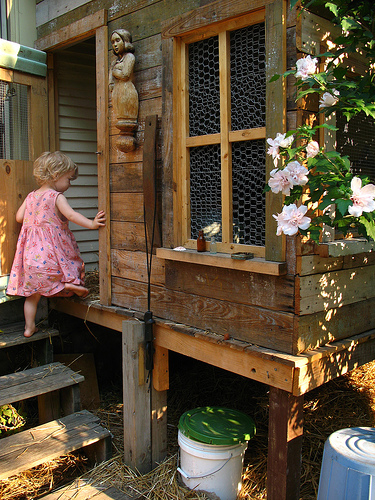

In [106]:
from PIL import Image
tmp_image_filename = '../Datasets/Flickr8k\\Flickr8k_Dataset/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg'
Image.open(tmp_image_filename)

In [107]:
from keras.preprocessing import image

def preprocess_input(x):  # 将数值范围映射到0..1之间
    x /= 255.
#     x -= 0.5
#     x *= 2.
    return x

def preprocess(image_path, target_size=(299, 299)):
    img = image.load_img(image_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    x = preprocess_input(x)
    return x

D:\Anaconda3\Anaconda3_py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<class 'numpy.ndarray'> (1, 299, 299, 3)


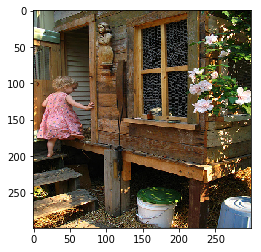

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
tmp_x = preprocess(tmp_image_filename)
print(type(tmp_x), tmp_x.shape)
plt.imshow(np.squeeze(tmp_x))

**接下来构建特定的卷积神经网络。**

可供使用的预训练网络：
- VGG-16
- VGG-19
- GoogleNet Inception V3
- ResNet50
- Xception
- IncetionResNetV2
- MobileNet

等

In [ ]:
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet50 import ResNet50
# from keras.applications.xception import Xception
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications.mobilenet import MobileNet
# 不能这样加载，会内存不够！！！
# def pretrain_model(modelname, weights=None, include_top=False):
#     if modelname == 'vgg16':
#         return VGG16(weights=weights, include_top=include_top)
#     if modelname == 'vgg19':
#         return  VGG19(weights=weights, include_top=include_top)
#     if modelname == 'inception_v3':
#         return InceptionV3(weights=weights, include_top=include_top)
#     if modelname == 'resnet50 ':
#         return ResNet50(weights=weights, include_top=include_top)
#     if modelname == 'xception':
#         return Xception(weights=weights, include_top=include_top)
#     if modelname == 'InceptionResNetV2 ':
#         return InceptionResNetV2(weights=weights, include_top=include_top)
#     if modelname == 'mobilenet ':
#         return MobileNet(weights=weights, include_top=include_top)
#     
#     return None

In [1]:
from keras.applications.inception_v3 import InceptionV3

inception_v3_model = InceptionV3(weights='imagenet')

D:\Anaconda3\Anaconda3_py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pickle

try:
    with open('save/all_captions_dict.pyc', 'rb') as load_all_captions_dict:
        all_captions_dict = pickle.load(load_all_captions_dict)
except Exception as e:
    print('Error: ', e)
print(type(all_captions_dict), len(all_captions_dict))

<class 'dict'> 8092
